# Model Creation - Logistic Regression Classifier

In [40]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### Read Data and Dropping Unused Columns for Model

In [23]:
df = pd.read_csv('/Users/briantreftz/GitHubRepos/Data/ProcessedData/DF_from_Feature_Sel_for_Model_Sel.csv')

In [24]:
# Define dataset
df = df[['Month', 'Week_Day', 'Origin', 'Destination',
        'Scheduled_Departure_Time', 'Scheduled_Arrival_Time',
        'Delayed']].copy()

### Build Model

In [33]:
# Combine Origin and Destination to get all unique values
combined_values = pd.concat([df['Origin'], df['Destination']])

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the combined unique values
label_encoder.fit(combined_values)

# Apply the encoding to both columns in the dataset
df['Origin'] = label_encoder.transform(df['Origin'])
df['Destination'] = label_encoder.transform(df['Destination'])

# Initialize and apply label encoders for Month and Week_Day
month_encoder = LabelEncoder()
week_day_encoder = LabelEncoder()

df['Month'] = month_encoder.fit_transform(df['Month'])
df['Week_Day'] = week_day_encoder.fit_transform(df['Week_Day'])

# Define dataset and target variable
X = df.drop('Delayed', axis=1)  # Features (all columns except 'Delayed')
y = df['Delayed']               # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Numerical columns for standard scaling
num_cols = ['Scheduled_Departure_Time', 'Scheduled_Arrival_Time']

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols)
    ], remainder='passthrough')

# Define the full pipeline including classifier
clf_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=1, max_iter=1000))
])

# Fit the pipeline on training data
clf_lr.fit(X_train, y_train)

# Predictions on test data
y_pred_lr = clf_lr.predict(X_test)

### Initial Model Performance


Confusion Matrix:
 [[157705 117007]
 [105807 168062]]
Accuracy: 0.5938357325536248
F1 Score: 0.6013618684004308
ROC AUC Score: 0.5938661470798263


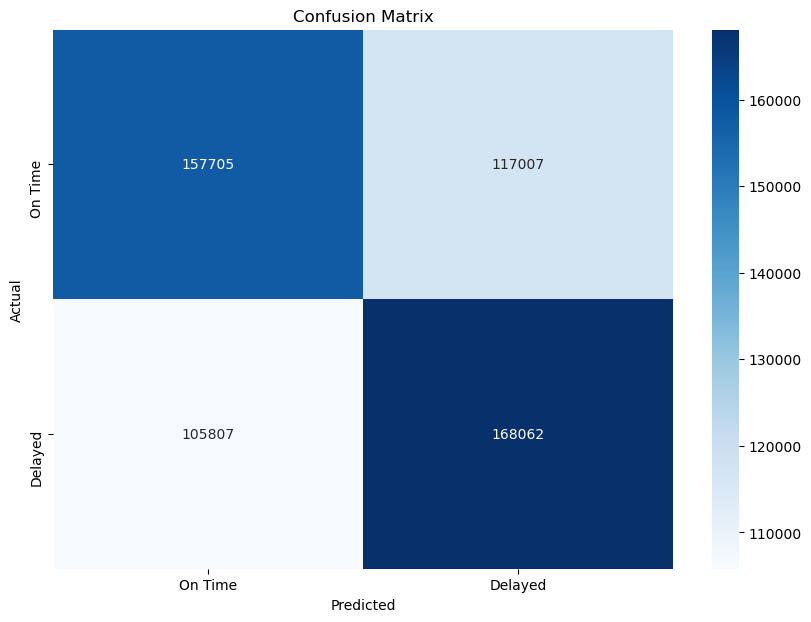

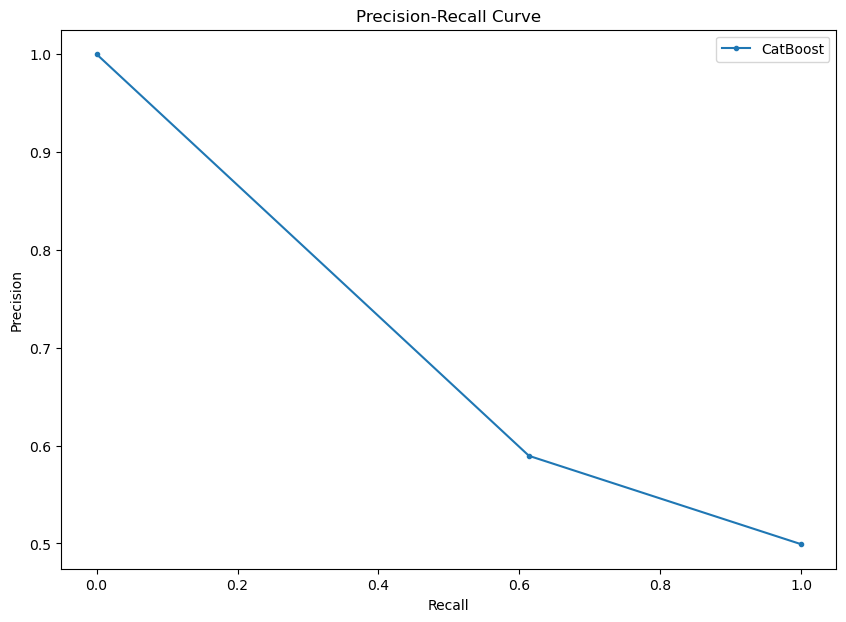

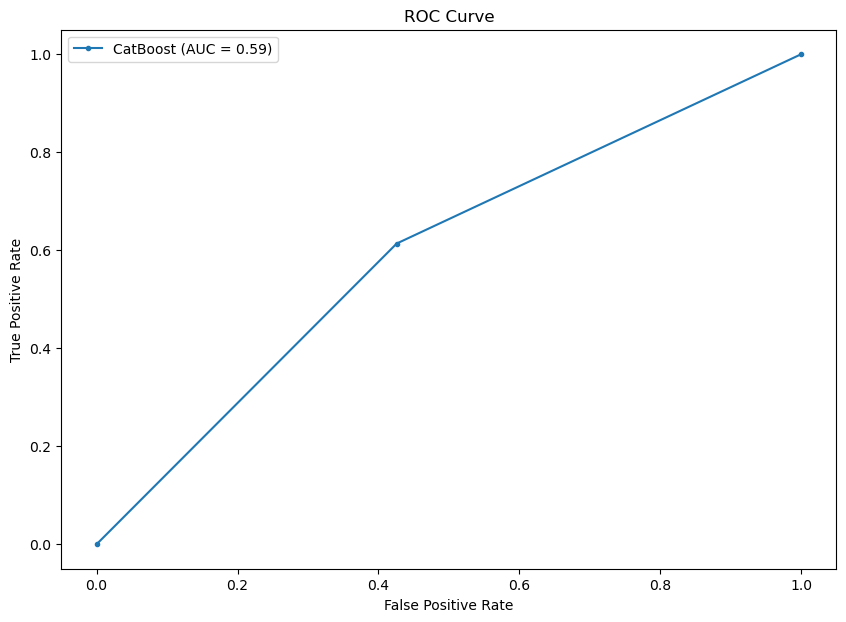

In [36]:
# Calculate confusion matrix
cm_init = confusion_matrix(y_test, y_pred_lr)

# Calculate precision and recall
precision_init, recall_init, _ = precision_recall_curve(y_test, y_pred_lr)

# Calculate ROC curve
fpr_init, tpr_init, _ = roc_curve(y_test, y_pred_lr)

# Calculate ROC AUC score
roc_auc_init = roc_auc_score(y_test, y_pred_lr)

# Calculate evaluation metrics
accuracy_init = accuracy_score(y_test, y_pred_lr)
f1_init = f1_score(y_test, y_pred_lr)

# Print evaluation metrics
print("\nConfusion Matrix:\n", cm_init)
print("Accuracy:", accuracy_init)
print("F1 Score:", f1_init)
print("ROC AUC Score:", roc_auc_init)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_init, annot=True, fmt='d', cmap='Blues', xticklabels=['On Time', 'Delayed'], yticklabels=['On Time', 'Delayed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 7))
plt.plot(recall_init, precision_init, marker='.', label='CatBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr_init, tpr_init, marker='.', label='CatBoost (AUC = %0.2f)' % roc_auc_init)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Summary

- #### The model has an accuracy of about 59.38%, meaning it correctly classifies approximately 59% of the instances.
- #### The F1 score, which balances precision and recall, is approximately 60.14%, indicating moderate performance.
- #### The ROC AUC score is about 59.39%, suggesting that the model has some capability to distinguish between the two classes, but there is significant room for improvement.

#### Overall, while the model demonstrates some capability to classify the data, its performance metrics indicate that there is substantial room for improvement.


## k-Folds Cross Validation

In [39]:
# Defining k-Folds Cross Validation parameters
accuracies = cross_val_score(estimator = clf_lr,
                    X = X,
                    y = y,
                    scoring = 'accuracy',
                    cv = 10)

print("Accuracy: {:.3f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.3f}".format(accuracies.std()))

Accuracy: 59.340 %
Standard Deviation: 0.001


## k-Folds Cross Validation Summary

#### Accuracy: The accuracy of 59.340% suggests that your model is correctly predicting the target variable approximately 59.3% of the time. This accuracy will serve as a baseline to gauge improvement after hyperparameter tuning.

#### Standard Deviation: The standard deviation of 0.001 (or 0.1%) indicates that the accuracy across different folds is very consistent, suggesting that your model's performance is stable across the dataset splits.


## Hyperparameter Tuning

In [41]:
# Define hyperparameters for Logistic Regression
parameters = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],      # Regularization strength
    'classifier__solver': ['lbfgs', 'liblinear'],       # Optimization algorithm
    'classifier__penalty': ['l2'],                      # Regularization type
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=clf_lr,
                        param_grid=parameters,
                        scoring='accuracy',
                        cv=10)

# Fit GridSearchCV
grid_search.fit(X, y)

# Get best score and parameters
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.3f} %".format(best_accuracy * 100))
print("Best Parameters:", best_parameters)



Best Accuracy: 59.341 %
Best Parameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


## Tuned Model Creation

In [42]:
# Define the full pipeline including classifier with tuned hyperparameters
lr_opt_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        C=best_parameters['classifier__C'],
        solver=best_parameters['classifier__solver'],
        penalty=best_parameters['classifier__penalty'],
        random_state=1,
        max_iter=1000))  # Specified Hyperparameters
])

# Fit the pipeline on training data
lr_opt_model.fit(X_train, y_train)

# Predictions on test data
y_pred_lr_opt = lr_opt_model.predict(X_test)

## Model Performance after Hyperparameter Tuning

Confusion Matrix:
 [[157799 116913]
 [105872 167997]]
Accuracy: 0.5938885962145973
F1 Score: 0.6013003351951308
ROC AUC Score: 0.5939185654717982


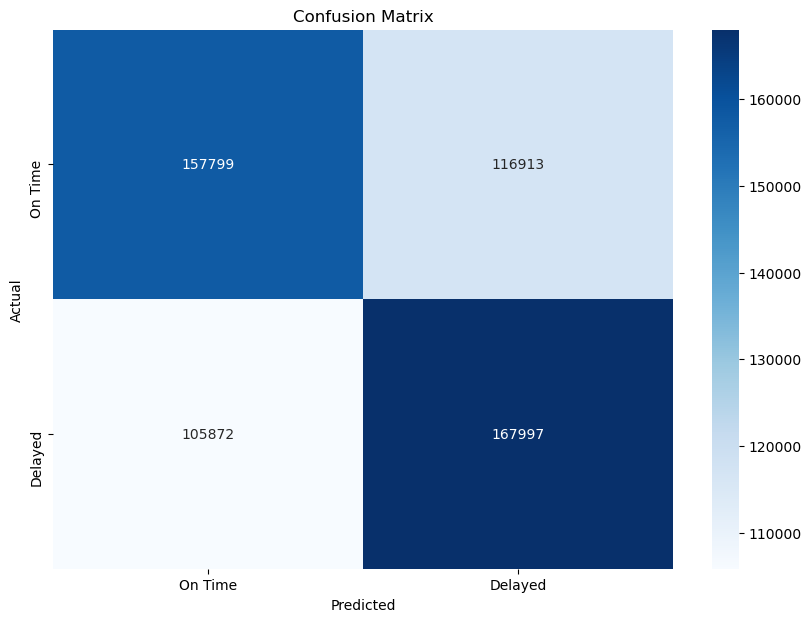

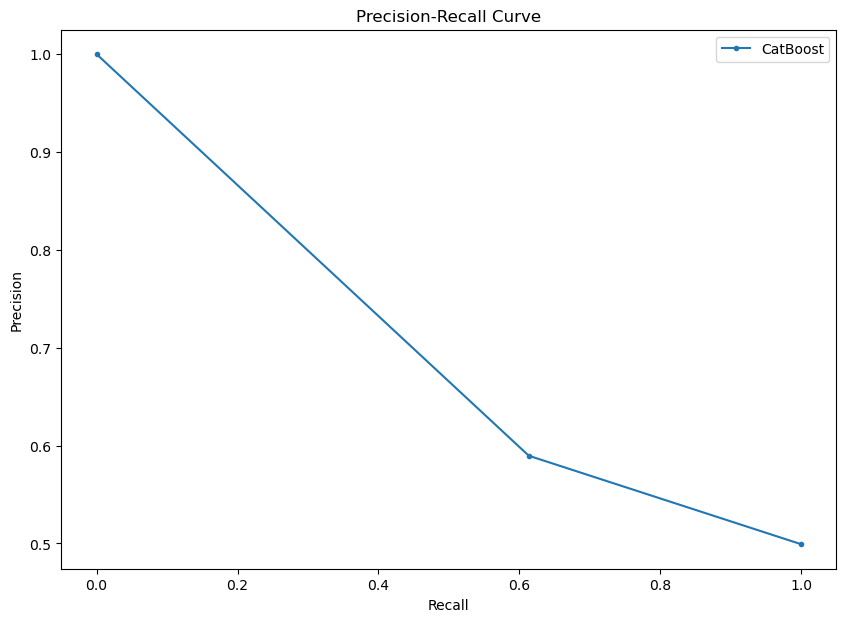

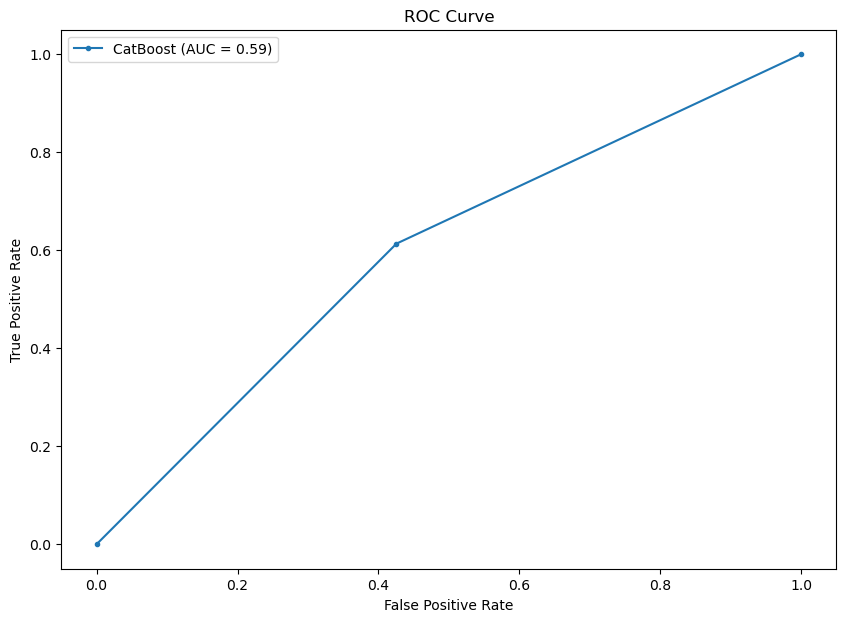

In [46]:
# Calculate confusion matrix
cm_opt = confusion_matrix(y_test, y_pred_lr_opt)

# Calculate precision and recall
precision_opt, recall_opt, _ = precision_recall_curve(y_test, y_pred_lr_opt)

# Calculate ROC curve
fpr_opt, tpr_opt, _ = roc_curve(y_test, y_pred_lr_opt)

# Calculate ROC AUC score
roc_auc_opt = roc_auc_score(y_test, y_pred_lr_opt)

# Calculate evaluation metrics
accuracy_opt = accuracy_score(y_test, y_pred_lr_opt)
f1_opt= f1_score(y_test, y_pred_lr_opt)

# Display metrics
print("Confusion Matrix:\n", cm_opt)
print("Accuracy:", accuracy_opt)
print("F1 Score:", f1_opt)
print("ROC AUC Score:", roc_auc_opt)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues', xticklabels=['On Time', 'Delayed'], yticklabels=['On Time', 'Delayed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 7))
plt.plot(recall_opt, precision_opt, marker='.', label='CatBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr_opt, tpr_opt, marker='.', label='CatBoost (AUC = %0.2f)' % roc_auc_opt)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## k-Folds Cross Validation of Model after Hyperparameter Tuning

In [47]:
# Defining k-Folds Cross Validation parameters
accuracies = cross_val_score(estimator = lr_opt_model,
                    X = X,
                    y = y,
                    scoring = 'accuracy',
                    cv = 10)

print("Accuracy: {:.3f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.3f}".format(accuracies.std()))

Accuracy: 59.341 %
Standard Deviation: 0.001


## Final Model Summary  
- #### Model Performance: After hyperparameter tuning, the Logistic Regression model achieved an accuracy of approximately 59.34%. This accuracy reflects the model's ability to correctly classify the target variable about 59.3% of the time on unseen data.  

- #### k-Folds Cross Validation: The cross-validation process revealed an accuracy of 59.34% with a standard deviation of 0.001. The low standard deviation indicates that the model's performance is stable and consistent across different folds of the dataset.  

- #### Hyperparameter Tuning: The hyperparameter tuning process optimized the Logistic Regression model, although the improvement in accuracy was minimal. The results suggest that further model refinement or the exploration of alternative algorithms might be necessary to achieve higher accuracy.
  
#### Overall, the model demonstrates consistent performance, but there is room for further enhancement. Additional techniques or models may be explored in future versions of this project to improve classification accuracy.